## Simulation for biallelic dynamics of SCN1A

This code implements empirical recordings of mutant sodium channel gating behaviour in a Hodgkin Huxley model of cortical neuronal firing. A live version of this notebook can be opened in the [google colab](https://colab.research.google.com/github/roschkoenig/SodMod/blob/master/example_noteboks/Single_Cell_Simulation.ipynb) interactive coding environment. This means you can trial some of the analysis without installing additional code. 

In [53]:
# The following section only needs to be executed when running off of google drive

# from google.colab import drive
# drive.mount('/content/drive')

# This needs to be run only once at the beginning to access the models
#-------------------------------------------------------------------------------
!pip install --upgrade git+https://github.com/roschkoenig/SodMod.git@Single_Cell_Playground
    
# import sys
# !{sys.executable} -m pip install -e '/Volumes/GoogleDrive/My Drive/Research/1906 SCN1A Biallelic Dynamics/02 - Scripts/sodmod'


Obtaining file:///Volumes/GoogleDrive/My%20Drive/Research/1906%20SCN1A%20Biallelic%20Dynamics/02%20-%20Scripts/sodmod
  Attempting uninstall: sodmod
    Found existing installation: sodmod 0.1
    Uninstalling sodmod-0.1:
      Successfully uninstalled sodmod-0.1
  Running setup.py develop for sodmod


In [54]:
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
from scipy.integrate import odeint
from itertools import repeat
from IPython.display import set_matplotlib_formats
# from google.colab import files
import matplotlib as mpl
import pickle
import os

import sodmod as sm
from sodmod import params as pr
from sodmod import cells as cl
from sodmod import incurr as ic
from sodmod import plot as pl

In [55]:
# Manual definitions
#===============================================================================
# Simulations
#-------------------------------------------------------------------------------
np.random.seed(1000)
F           = {'base': '/Volumes/GoogleDrive/My Drive/Research/1906 SCN1A Biallelic Dynamics/02 - Scripts/sodmod'}
F.update({'figs':F['base'] +os.sep+ 'figures'})

# Define parameters for the selected plot type
#-------------------------------------------------------------------------------
class sim_specs:
    def __init__(self, whichplot, itype = 'random', steps = None):
        self.name   = whichplot
        self.V0     = -80
        self.conds  = ['WT37', 'TI37', 'AS37']    # Conditions to be modelled
        self.cols   = ['k', 'r', 'b']             # Colours for plotting 
        self.cmaps  = [plt.get_cmap('Greys'), 
                       plt.get_cmap('Reds'), 
                       plt.get_cmap('Blues')]
        self.ctyp   = 'PY'

        if whichplot == 'sweep':
            self.ptype      = 'sweep'
            self.paradigm   = 'constant'
            self.T          = np.linspace(0,250,5000)
            self.steps      = steps if steps else 30

        if whichplot == 'bifurcation':
            self.ptype      = 'bifurcation'
            self.paradigm   = 'constant'
            self.T          = np.linspace(0,250,5000)
            self.steps      = steps if steps else 30

        if whichplot == 'ramp':
            self.ptype      = 'timeseries'
            self.paradigm   = 'ramp'              
            self.T          = np.linspace(0,1000,10000) 
        
    def initialise(self, itype = 'random'):
        if itype == 'random':
            V0 = {}
            for c in self.conds:
                testpar = pr.params(self.conds[0], 0, self.ctyp, self.paradigm,
                                    NaP_scl = 0)
                v0 = np.random.rand(1,len(testpar['snames']))
                v0[0,0] = self.V0
                V0.update({c:v0})
            
        if itype == 'preset_baseline_same':
            V0 = {'WT37':np.array([[-69, 0.01, 0.01, 1.00, 0.24, 0.03]]), 
                  'AS37':np.array([[-69, 0.01, 0.01, 1.00, 0.24, 0.03]]), 
                  'TI37':np.array([[-69, 0.01, 0.01, 1.00, 0.24, 0.03]])}
            
        if itype == 'preset_baseline_types':
            # These values are derived from running a few simulations until steady state is achieved 
            V0 = {'WT37':np.array([[-67.72, 0.017, 0.016, 1.00, 0.03, 0.04]]),
                  'AS37':np.array([[-68.48, 0.015, 0.010, 1.00, 0.02, 0.03]]), 
                  'TI37':np.array([[-56.18, 0.072, 0.083, 0.87, 0.24, 0.08]])}

        self.Y0 = V0
        return self


# Parameter Sweep 
One of the key parameters that differs between mutants and wild types is not included in the standard HH formulations of cortical neurons: the conductance associated with the __persistent sodium current__. In order to identify ranges of this parameter that still allow firing of neurons, we have implemented a parameter sweep. 

For this, we scale the contribution of persistant sodium currents to the overall sodium conductance, whilst preserving relative differences between the HH models of different mutants. For each value of this _scaling parameter_, we then evaluate the range of input currents for which the neurons still fire. 

### Relevant variables in code below

- __`Na_scl`__: scaling parameter that adjusts the relative contribution of the persistent sodium current
- __`I_scl`__: scaling parameter that adjusts the input current for each model run
- __`Vy`__: This is a two dimensional array (of the scale $n*m$, where $n$  is the length of `Na_scl`, and $m$ is the length of `I_scl`) that contains all simulations. Each element of the array is a dictionary, which contains one simulated time series for each condition. 

In [56]:
specs = sim_specs('sweep', steps = 30).initialise('preset_baseline_types')
if specs.name == 'sweep':

    # Define conditions to be tested
    #-----------------------------------------------------------------------------
    I_scl  = np.exp(np.linspace(-6,6,specs.steps))
    Na_scl = np.exp(np.linspace(-3,0,specs.steps))

    Vy = []
    ni = 0
    
    print('Simulating different scaling for the persistent sodium current:')
    for n in Na_scl:
        print('Currently runnning simulation No. ' +str(ni+1)+ '/' +str(len(Na_scl)))
        vy = []
        for i in I_scl:
            if len(vy) == 0: vy.append(cl.runsim(i, n, specs, specs.Y0)) 
            else: vy.append(cl.runsim(i, n, specs, vy[-1]))
        Vy.append(vy)
        ni = ni + 1
        
sw = {'Y':Vy, 'I':I_scl, 'N':Na_scl, 'S':specs}   # Package up for plotting 

Simulating different scaling for the persistent sodium current:
Currently runnning simulation No. 1/30
Currently runnning simulation No. 2/30
Currently runnning simulation No. 3/30
Currently runnning simulation No. 4/30
Currently runnning simulation No. 5/30
Currently runnning simulation No. 6/30
Currently runnning simulation No. 7/30
Currently runnning simulation No. 8/30
Currently runnning simulation No. 9/30
Currently runnning simulation No. 10/30
Currently runnning simulation No. 11/30
Currently runnning simulation No. 12/30
Currently runnning simulation No. 13/30
Currently runnning simulation No. 14/30
Currently runnning simulation No. 15/30
Currently runnning simulation No. 16/30
Currently runnning simulation No. 17/30
Currently runnning simulation No. 18/30
Currently runnning simulation No. 19/30
Currently runnning simulation No. 20/30
Currently runnning simulation No. 21/30
Currently runnning simulation No. 22/30
Currently runnning simulation No. 23/30
Currently runnning simula

### Parameter sweep plot
Below we plot the results of the parameter sweep: On the left we plot the bifurcation plots with control-parameter `I_scl`, for various values of `Na_scl`. On the left we show the same data, but now showing the two-dimensional map of the two parameters, with each pixel representing the oscillatory amplitude for the particular parameter bin.

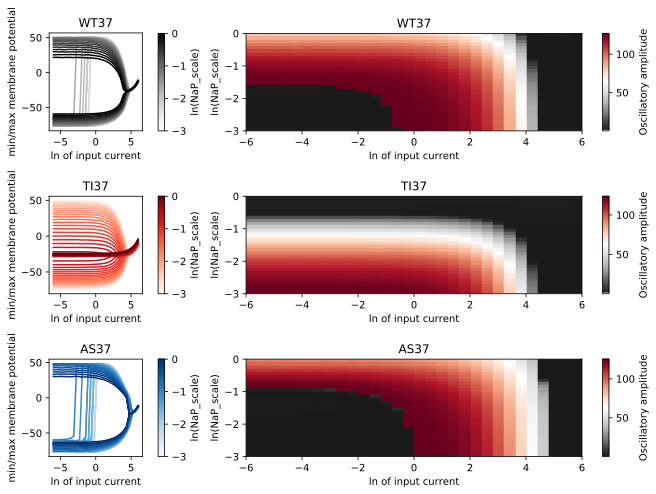

In [67]:
reload(pl)
set_matplotlib_formats('svg')
pl.sweep(sw['Y'], sw['I'], sw['N'], sw['S'], figscale = 1.5)
if False: plt.savefig(F['figs'] +os.sep+ sw['S'].name + '.svg')

# Bifurcation analysis
Based on the analysis above, we choose a persistent sodium current value for which all three neuronal classes have at least some firing activity. For these, we rerun the simulation above in finer granularity and both forwards and backwards in order to identify the bifurcation behaviour of each of the neurons

In [58]:
reload(cl)

specs = sim_specs('bifurcation', steps = 150).initialise('preset_baseline_types')
if specs.name == 'bifurcation':

    # Define conditions to be tested
    #-------------------------------------------------------------------------------
    I_scl = np.exp(np.linspace(-6,6,specs.steps))      # Input currents to be modelled
    Na_scl = np.exp(-2.5)

    # Looped execution (for bifurcation analysis)
    #-------------------------------------------------------------------------------
    print('Running forward simulation')
    Vy_fwd = []
    I_fwd  = []
    for i in I_scl:
        if len(Vy_fwd) == 0:  Vy_fwd.append(cl.runsim(i, Na_scl, specs))
        else:                 Vy_fwd.append(cl.runsim(i, Na_scl, specs, Vy_fwd[-1]))
        I_fwd.append(i)
  
    print('Running backward simulation')
    Vy_bwd = []
    I_bwd  = []
    for i in np.flip(I_scl):
        if len(Vy_bwd) == 0:  Vy_bwd.append(cl.runsim(i, Na_scl, specs))
        else:                 Vy_bwd.append(cl.runsim(i, Na_scl, specs, Vy_bwd[-1]))
        I_bwd.append(i)  

bf = {'Yf':Vy_fwd, 'Yb':Vy_bwd, 'If':I_fwd, 'Ib':I_bwd, 'N':Na_scl, 'S':specs}

Running forward simulation
Running backward simulation


### Bifurcation plot
This produces a 'classical' bifurcation plot of neuronal firing - by changing the input current gradually between different values, we identify the 'firing threshold' for each of the parameterisations of the Hodgkin Huxley model. This is similar to the analysis done above, but includes more steps, and a forward and backward sweep to identify areas of bistability in the model. 

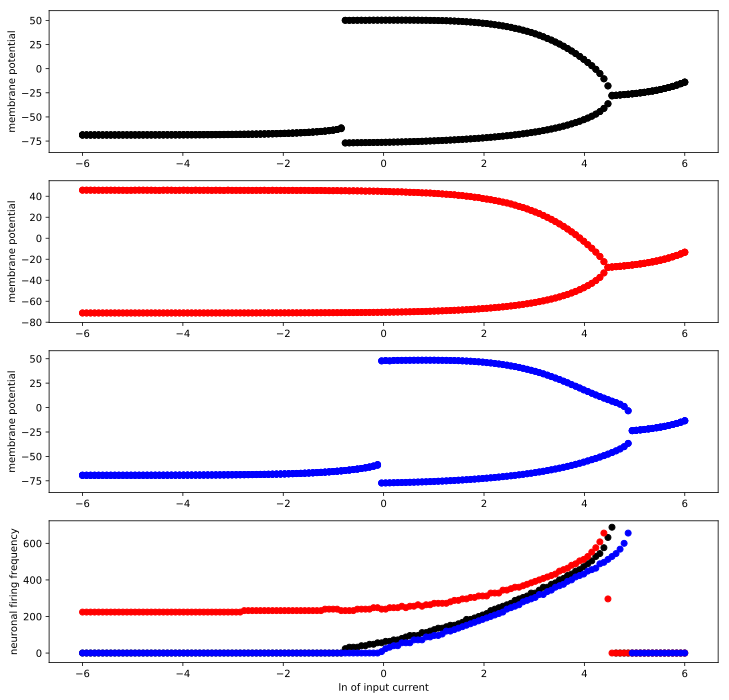

In [68]:
reload(pl) 
set_matplotlib_formats('svg')
pl.bifurcation(bf['Yf'], bf['Yb'], bf['If'], bf['Ib'], bf['S'], figscale = 1)
if False: plt.savefig(F['figs'] +os.sep+ bf['S'].name + '.svg')

### Phase space plot
A different representation of the data are the phase space plots. By plotting the different time varying states against each other (rather than against time), we can demonstrate the stereotyped nature of the oscillations (representing stable limit cycles) and their similarities and dissimilarities across conditions. 

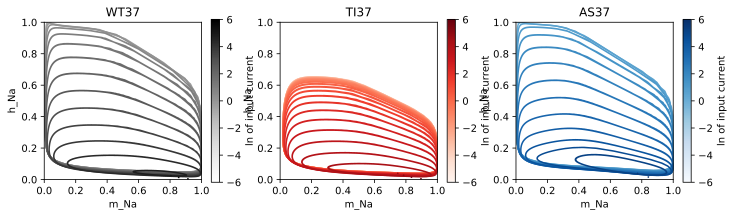

In [69]:
reload(pl)
set_matplotlib_formats('svg')
pl.phasespace(bf['Yf'], bf['If'], bf['S'], Nplots = 30, states = ['m_Na', 'h_Na'], figscale = 1)
if False: plt.savefig(F['figs'] +os.sep+ 'phase_space.svg')

# Example time series
To visualise the neuronal firing patterns across the range of the input currents, we plot the firing for an exponential ramp of input currents. 

In [61]:
specs   = sim_specs('ramp').initialise('preset_baseline_types')
I_scl   = np.exp(6)         # Maximum input current achieved by the ramp 
NaP_scl = np.exp(-2.5)      # Na_scl value as identified above 

if specs.name == 'ramp':
    Vy       = [cl.runsim(I_scl, NaP_scl, specs, specs.Y0)]

rp = {'Y':Vy, 'I':I_scl, 'S':specs, 'N':NaP_scl}

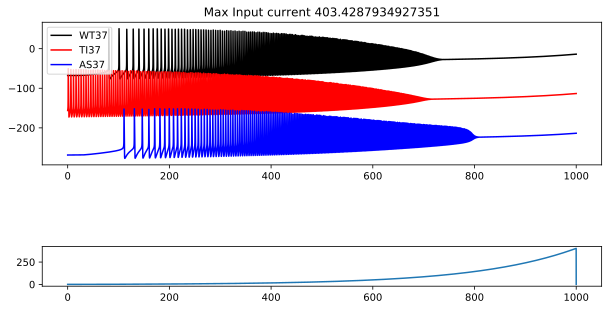

In [62]:
reload(pl)
set_matplotlib_formats('svg')
pl.timeseries(rp['Y'], rp['I'], rp['S'], figscale=.7)
if False: plt.savefig(F['figs'] +os.sep+ specs.name + '.svg')

### Postscript
The following jupyter comman run in the command line will generate a markdown file that can be used as index page for the github repo

`jupyter nbconvert --to markdown Single_Cell_Simulation.ipynb`

In [8]:
! cp Single_Cell_Simulation.ipynb ../README.ipynb
!jupyter nbconvert --to markdown ../README.ipynb

[NbConvertApp] Converting notebook ../README.ipynb to markdown
[NbConvertApp] Support files will be in README_files/
[NbConvertApp] Making directory ../README_files
[NbConvertApp] Making directory ../README_files
[NbConvertApp] Making directory ../README_files
[NbConvertApp] Making directory ../README_files
[NbConvertApp] Writing 12784 bytes to ../README.md
